# Reconstructed observations - Phantom model
---

In [40]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from astropy     import units, constants
from pomme.model import TensorModel
from pomme.haar  import Haar
from pomme.plot  import plot_cube_2D
from pomme.utils import planck, T_CMB

from phantom import lines, fracs, velos, Model

from palettable.cubehelix import cubehelix2_16      # Nice colormap

In [2]:
import plons

setupData = plons.LoadSetup('/STER/frederikd/', "wind")
dumpData  = plons.LoadFullDump('/STER/frederikd/wind_00600', setupData)

position = dumpData["position"]*1e-2     # position vectors        [cm   -> m]
velocity = dumpData["velocity"]*1e3      # velocity vectors        [km/s -> m/s]
rho      = dumpData["rho"]               # density                 [g/cm^3]
tmp      = dumpData["Tgas"]              # temperature             [K]
tmp[tmp<T_CMB] = T_CMB                   # Cut-off temperatures below 2.725 K

v_x, v_y, v_z = velocity[:,0], velocity[:,1], velocity[:,2]

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02

# Define turbulence at 150 m/s
trb = 150.0

# Map point data to a regular grid
haar = Haar(position, q=8)

imin = 2**(haar.q-3)
imax = 3*imin

nH2_dat = haar.map_data(nH2, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]

assert tmp_dat.shape == nH2_dat.shape
assert tmp_dat.shape == v_z_dat.shape

model = TensorModel(shape=nH2_dat.shape, sizes=haar.xyz_L)
model['log_H2'          ] = np.log(nH2_dat).astype(np.float64)
model['log_temperature' ] = np.log(tmp_dat).astype(np.float64)
model['velocity_x'      ] =        v_x_dat .astype(np.float64)
model['velocity_y'      ] =        v_y_dat .astype(np.float64)
model['velocity_z'      ] =        v_z_dat .astype(np.float64)
model['log_v_turbulence'] = np.log(trb)*np.ones(model.shape, dtype=np.float64)

In [3]:
def get_boundary_condition(model, freq):
    Ibdy  = torch.ones((model.shape[0], model.shape[1], len(freq)), dtype=torch.float64)
    Ibdy *= planck(temperature=T_CMB, frequency=freq)
    return Ibdy

In [4]:
pmodel = Model(model=model, lines=lines, fracs=fracs, velos=velos)
pmodel.get_velocity           = lambda model: model['velocity_z']
pmodel.get_abundance          = lambda model: torch.exp(model['log_H2'])
pmodel.get_turbulence         = lambda model: torch.exp(model['log_v_turbulence'])
pmodel.get_temperature        = lambda model: torch.exp(model['log_temperature'])
pmodel.get_boundary_condition = get_boundary_condition

In [5]:
obss_2 = pmodel.image()

In [6]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import numpy as np
import torch
import plons

from matplotlib.lines import Line2D
from astropy          import constants, units

from pomme.model import TensorModel, SphericallySymmetric
from pomme.loss  import Loss
from pomme.haar  import Haar

In [7]:
name  = 'model_fit_it=600'
model = TensorModel.load(f'{name}.h5')
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_H2                     Free          True     +2.248e+01     +2.429e+01     +3.473e+01
  log_temperature            Free          True     +6.012e+00     +7.423e+00     +1.091e+01
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  log_velocity_r             Free          True     +5.134e+00     +9.193e+00     +1.021e+01
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


In [8]:
def get_velocity(model):
    d = torch.from_numpy(model.get_radial_direction(origin='centre'))    
    return torch.exp(model['log_velocity_r']) * d

def get_boundary_condition(model, freq):
    Ibdy  = torch.ones((model.shape[0], model.shape[1], len(freq)), dtype=torch.float64)
    Ibdy *= planck(temperature=T_CMB, frequency=freq)
    return Ibdy

In [9]:
pmodel = Model(model=model, lines=lines, fracs=fracs, velos=velos)
pmodel.get_velocity           = get_velocity
pmodel.get_abundance          = lambda model: torch.exp(model['log_H2'])
pmodel.get_turbulence         = lambda model: torch.exp(model['log_v_turbulence'])
pmodel.get_temperature        = lambda model: torch.exp(model['log_temperature'])
pmodel.get_boundary_condition = get_boundary_condition

In [10]:
obss = pmodel.image()

In [11]:
plot_cube_2D(np.log(obss[1].data))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [12]:
obss.shape

torch.Size([2, 64, 64, 100])

In [13]:
velos

tensor([-12000.0000, -11757.5758, -11515.1515, -11272.7273, -11030.3030,
        -10787.8788, -10545.4545, -10303.0303, -10060.6061,  -9818.1818,
         -9575.7576,  -9333.3333,  -9090.9091,  -8848.4848,  -8606.0606,
         -8363.6364,  -8121.2121,  -7878.7879,  -7636.3636,  -7393.9394,
         -7151.5152,  -6909.0909,  -6666.6667,  -6424.2424,  -6181.8182,
         -5939.3939,  -5696.9697,  -5454.5455,  -5212.1212,  -4969.6970,
         -4727.2727,  -4484.8485,  -4242.4242,  -4000.0000,  -3757.5758,
         -3515.1515,  -3272.7273,  -3030.3030,  -2787.8788,  -2545.4545,
         -2303.0303,  -2060.6061,  -1818.1818,  -1575.7576,  -1333.3333,
         -1090.9091,   -848.4848,   -606.0606,   -363.6364,   -121.2121,
           121.2121,    363.6364,    606.0606,    848.4848,   1090.9091,
          1333.3333,   1575.7576,   1818.1818,   2060.6061,   2303.0303,
          2545.4545,   2787.8788,   3030.3030,   3272.7273,   3515.1515,
          3757.5758,   4000.0000,   4242.4242,   44

In [14]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [15]:
model.sizes / (1.0 * units.au).si.value

array([499.14966283, 498.78355716, 492.07092181])

In [16]:
32 - 32 / 250 * 150

12.8

In [17]:
32 + 32 / 250 * 150

51.2

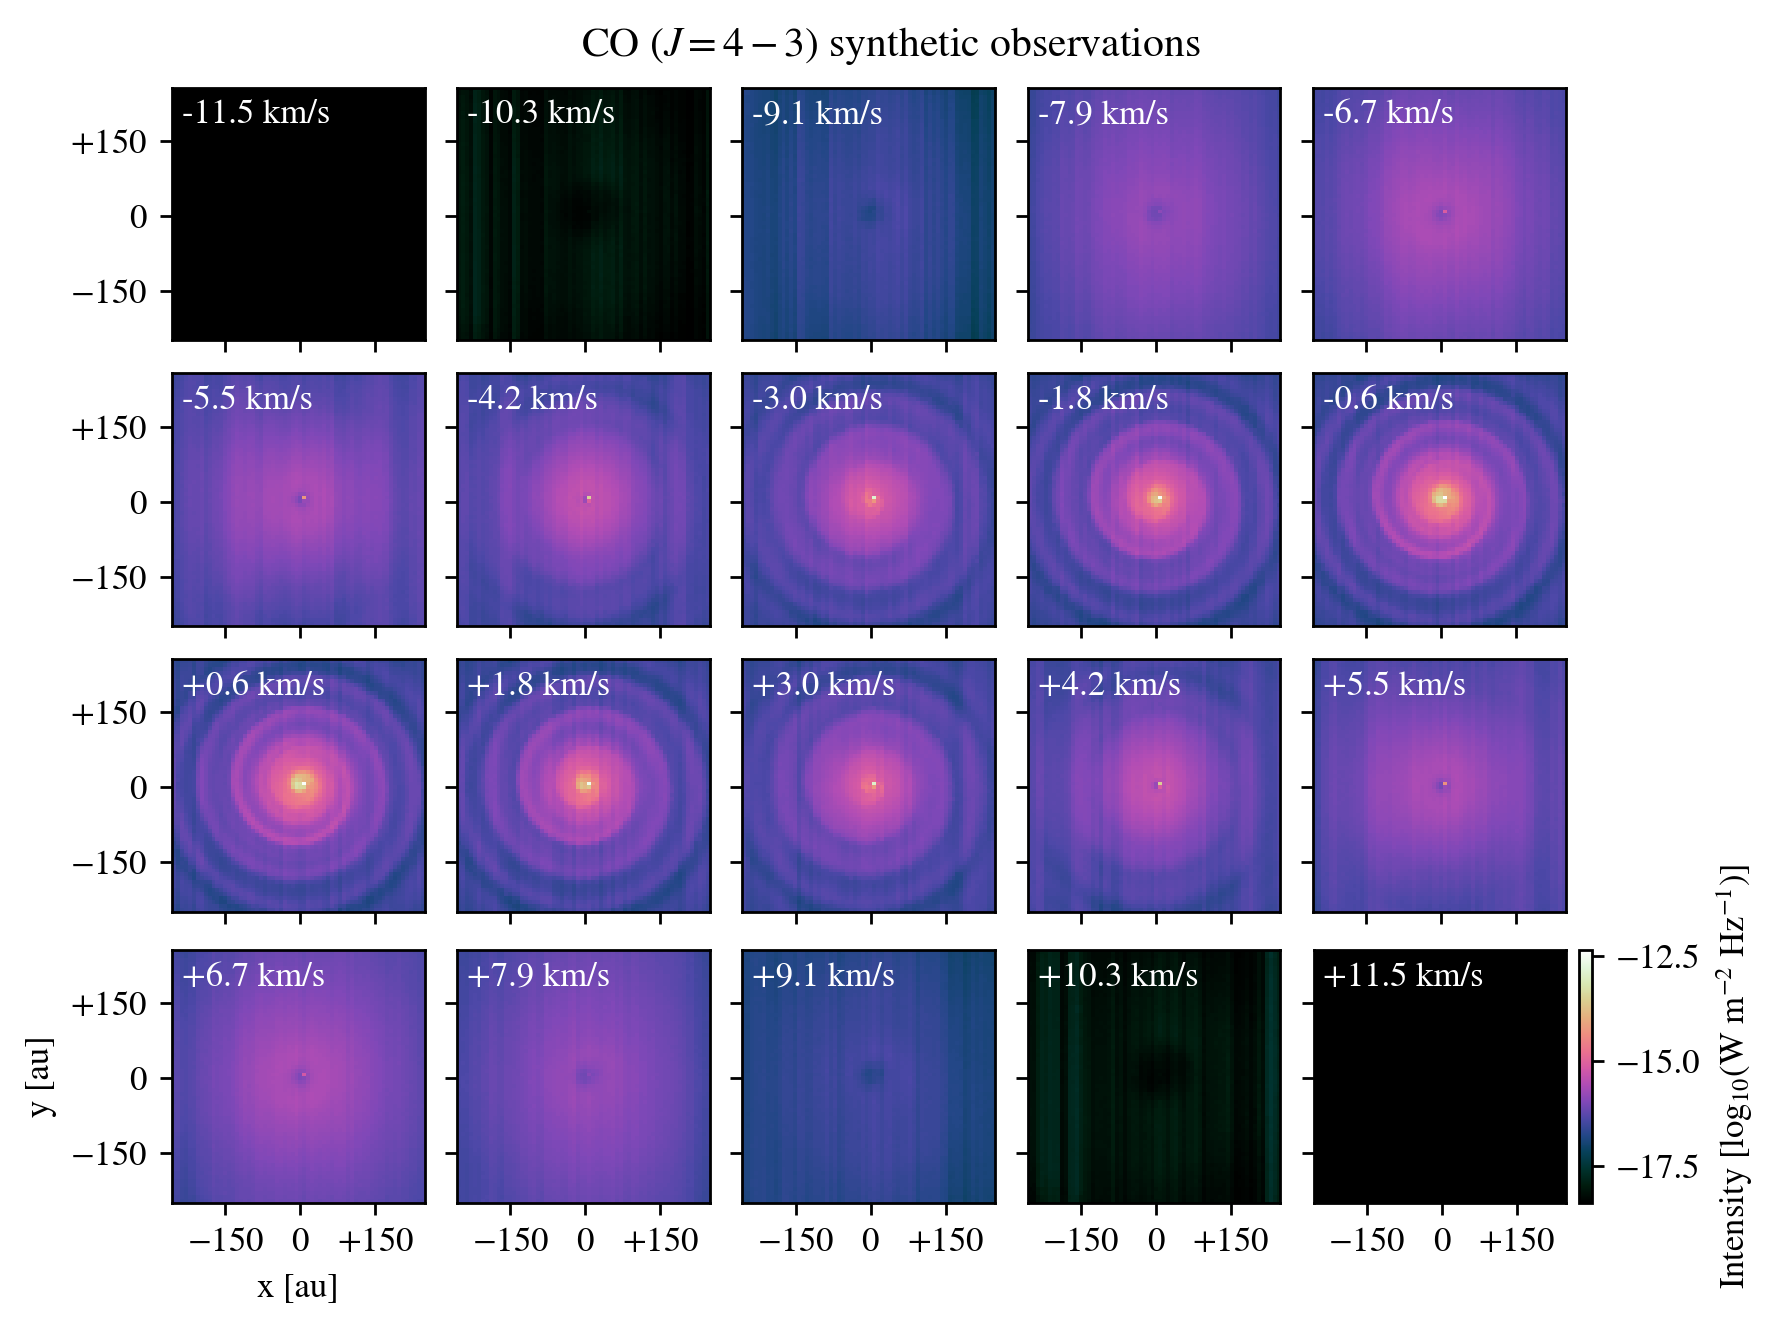

In [41]:
obs = obss_2[0]

vmin = np.log10(obs.min())
vmax = np.log10(obs.max())

fig, axes = plt.subplots(
    nrows       =   4,
    ncols       =   5,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (7, 5.2),
    # gridspec_kw = {'left':0, 'right':0.1, 'top':0.1, 'bottom':0}, #{'wspace':-1, 'hspace':-1},
    layout      = 'constrained'
)

fig.suptitle('CO $(J=4-3)$ synthetic observations')

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(np.log10(obs[:,:,5*i+2]), vmin=vmin, vmax=vmax, cmap=cubehelix2_16.mpl_colormap)
    ax.text(+2, +8.5, f'{velos[5*i+2]/1000:+.1f} km/s', color='white')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([13, 32, 51], ['$-150$', '$0$', '$+150$'])
    ax.set_yticks([13, 32, 51], ['$+150$', '$0$', '$-150$'])
    
axes[3,0].set_xlabel('x [au]')
axes[3,0].set_ylabel('y [au]')

fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='Intensity [log$_{10}$(W m$^{-2}$ Hz$^{-1}$)]')

plt.savefig('phantom_CO_obs_2.png', dpi=360)

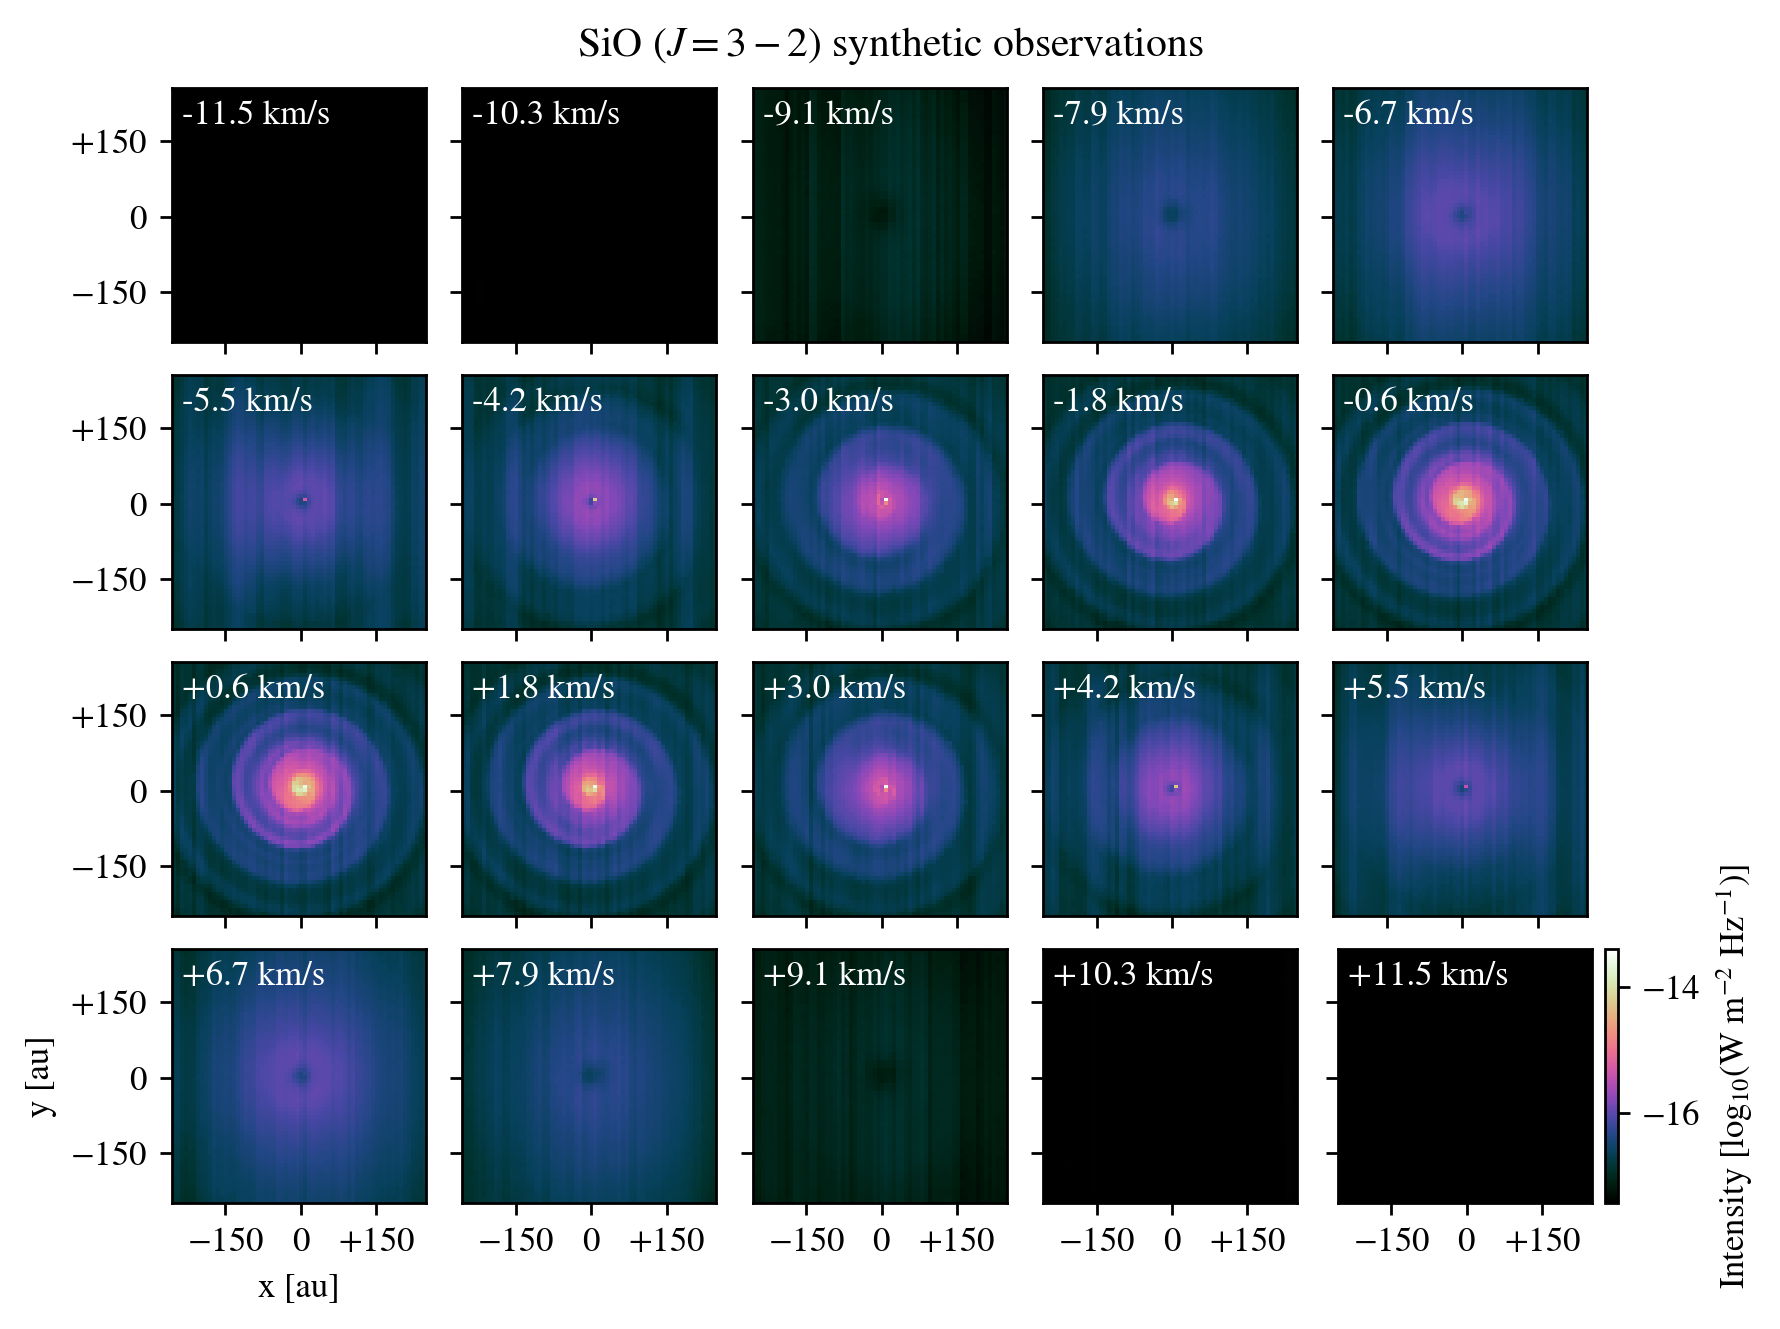

In [42]:
obs = obss_2[1]

vmin = np.log10(obs.min())
vmax = np.log10(obs.max())

fig, axes = plt.subplots(
    nrows       =   4,
    ncols       =   5,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (7, 5.2),
    # gridspec_kw = {'left':0, 'right':0.1, 'top':0.1, 'bottom':0}, #{'wspace':-1, 'hspace':-1},
    layout      = 'constrained'
)

fig.suptitle('SiO $(J=3-2)$ synthetic observations')

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(np.log10(obs[:,:,5*i+2]), vmin=vmin, vmax=vmax, cmap=cubehelix2_16.mpl_colormap)
    ax.text(+2, +8.5, f'{velos[5*i+2]/1000:+.1f} km/s', color='white')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([13, 32, 51], ['$-150$', '$0$', '$+150$'])
    ax.set_yticks([13, 32, 51], ['$+150$', '$0$', '$-150$'])
    
axes[3,0].set_xlabel('x [au]')
axes[3,0].set_ylabel('y [au]')

fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='Intensity [log$_{10}$(W m$^{-2}$ Hz$^{-1}$)]')

plt.savefig('phantom_SiO_obs_2.png', dpi=360)

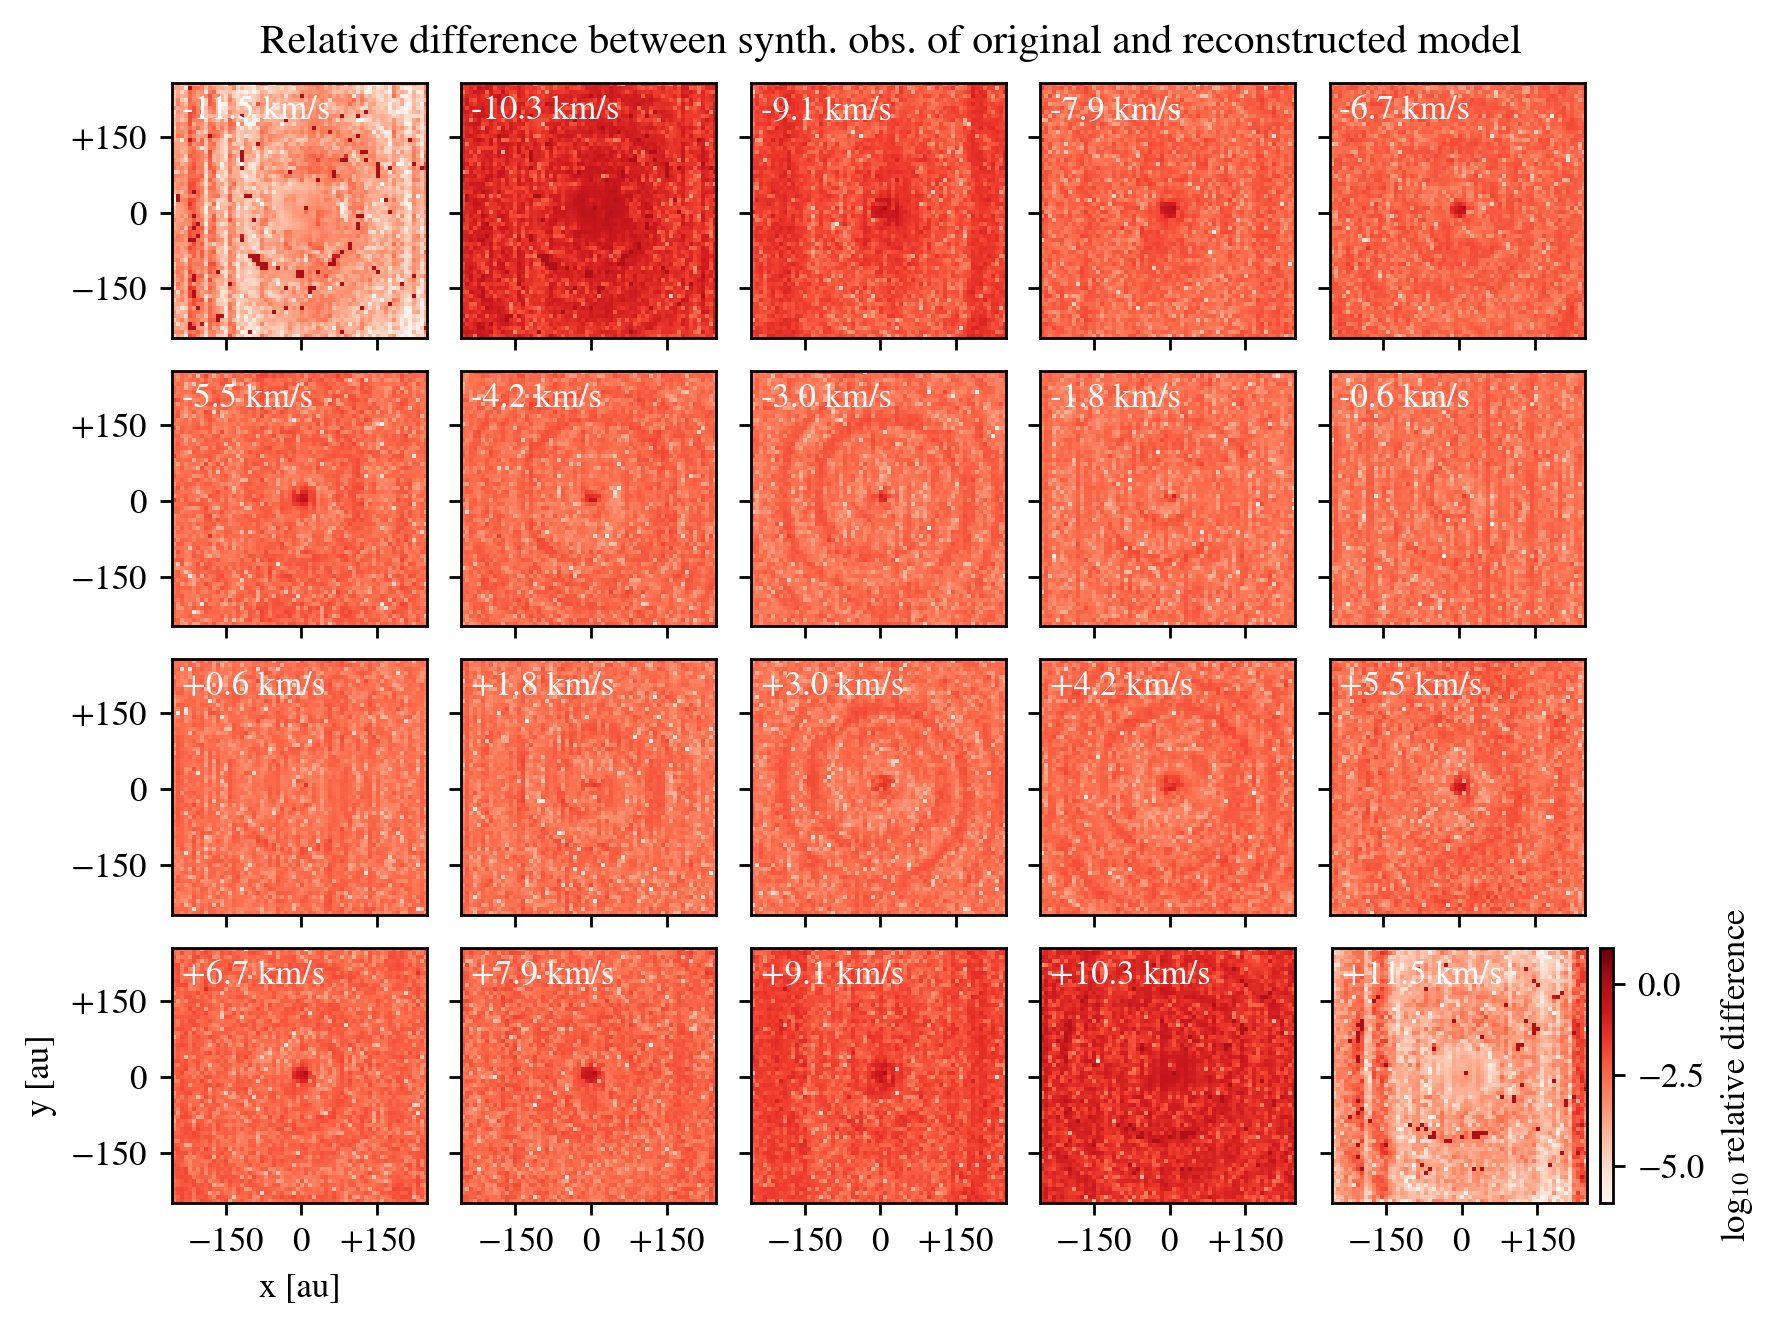

In [37]:
obs = np.abs(((obss[0]-obss_2[0])/obss[0]).data)

vmin = -6.0#np.log10(obs.min())
vmax =  1.0 #np.log10(obs.max())

fig, axes = plt.subplots(
    nrows       =   4,
    ncols       =   5,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (7, 5.2),
    gridspec_kw = {'wspace':-1.00, 'hspace':-1.00},
    layout      = 'constrained'
)

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(np.log10(obs[:,:,5*i+2]), vmin=vmin, vmax=vmax, cmap='Reds')
    ax.text(+2, +8.5, f'{velos[5*i+2]/1000:+.1f} km/s', color='white')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([13, 32, 51], ['$-150$', '$0$', '$+150$'])
    ax.set_yticks([13, 32, 51], ['$+150$', '$0$', '$-150$'])
    
axes[3,0].set_xlabel('x [au]')
axes[3,0].set_ylabel('y [au]')

fig.suptitle('Relative difference between synth. obs. of original and reconstructed model')

fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='log$_{10}$ relative difference')

plt.savefig('phantom_CO_obs_rec.png', dpi=360)

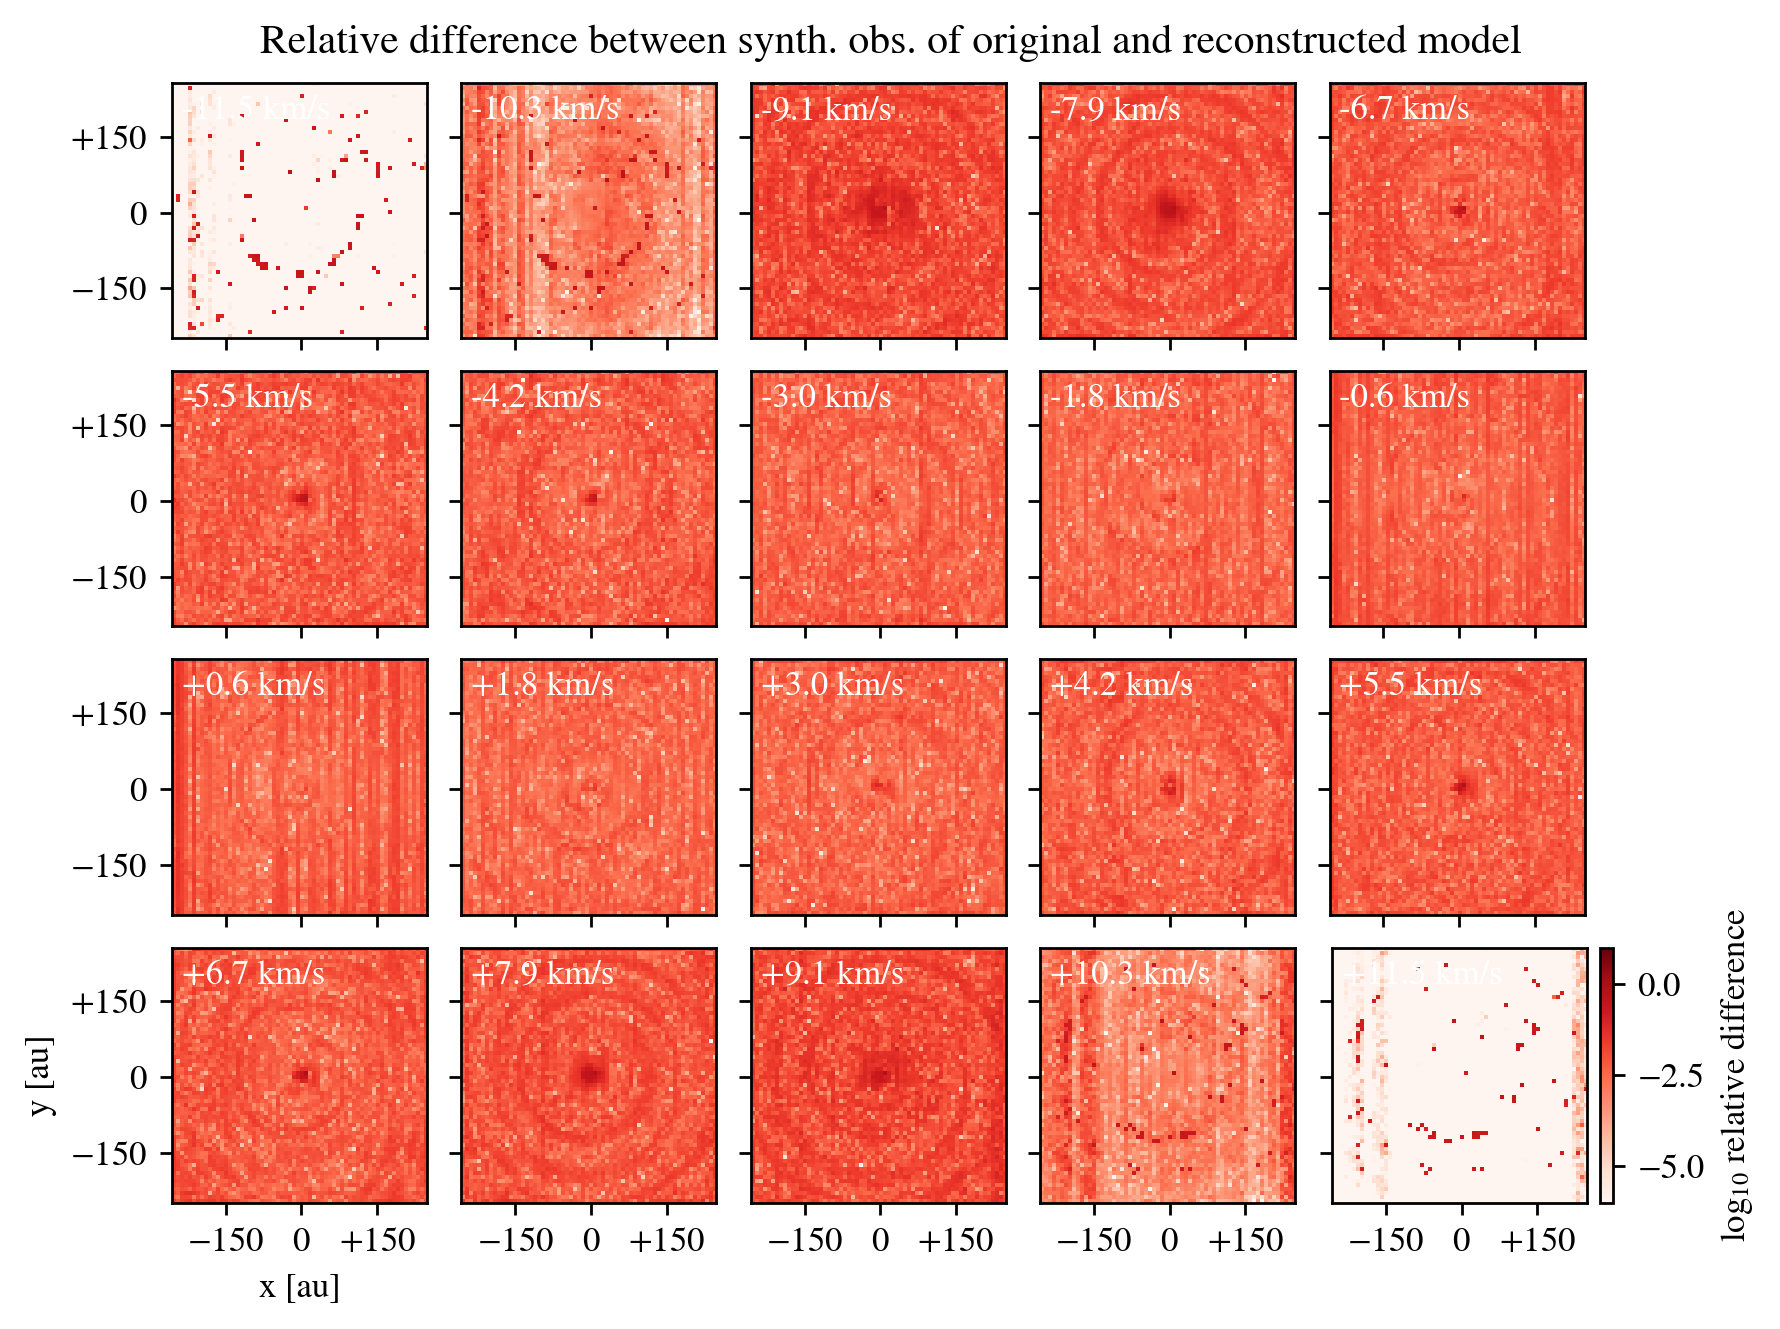

In [43]:
obs = np.abs(((obss[1]-obss_2[1])/obss[1]).data)

vmin = -6.0#np.log10(obs.min())
vmax =  1.0 #np.log10(obs.max())

fig, axes = plt.subplots(
    nrows       =   4,
    ncols       =   5,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (7, 5.2),
    gridspec_kw = {'wspace':-1.00, 'hspace':-1.00},
    layout      = 'constrained'
)

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(np.log10(obs[:,:,5*i+2]), vmin=vmin, vmax=vmax, cmap='Reds')
    ax.text(+2, +8.5, f'{velos[5*i+2]/1000:+.1f} km/s', color='white')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([13, 32, 51], ['$-150$', '$0$', '$+150$'])
    ax.set_yticks([13, 32, 51], ['$+150$', '$0$', '$-150$'])
    
axes[3,0].set_xlabel('x [au]')
axes[3,0].set_ylabel('y [au]')

fig.suptitle('Relative difference between synth. obs. of original and reconstructed model')

fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='log$_{10}$ relative difference')

plt.savefig('phantom_SiO_obs_rec.png', dpi=360)

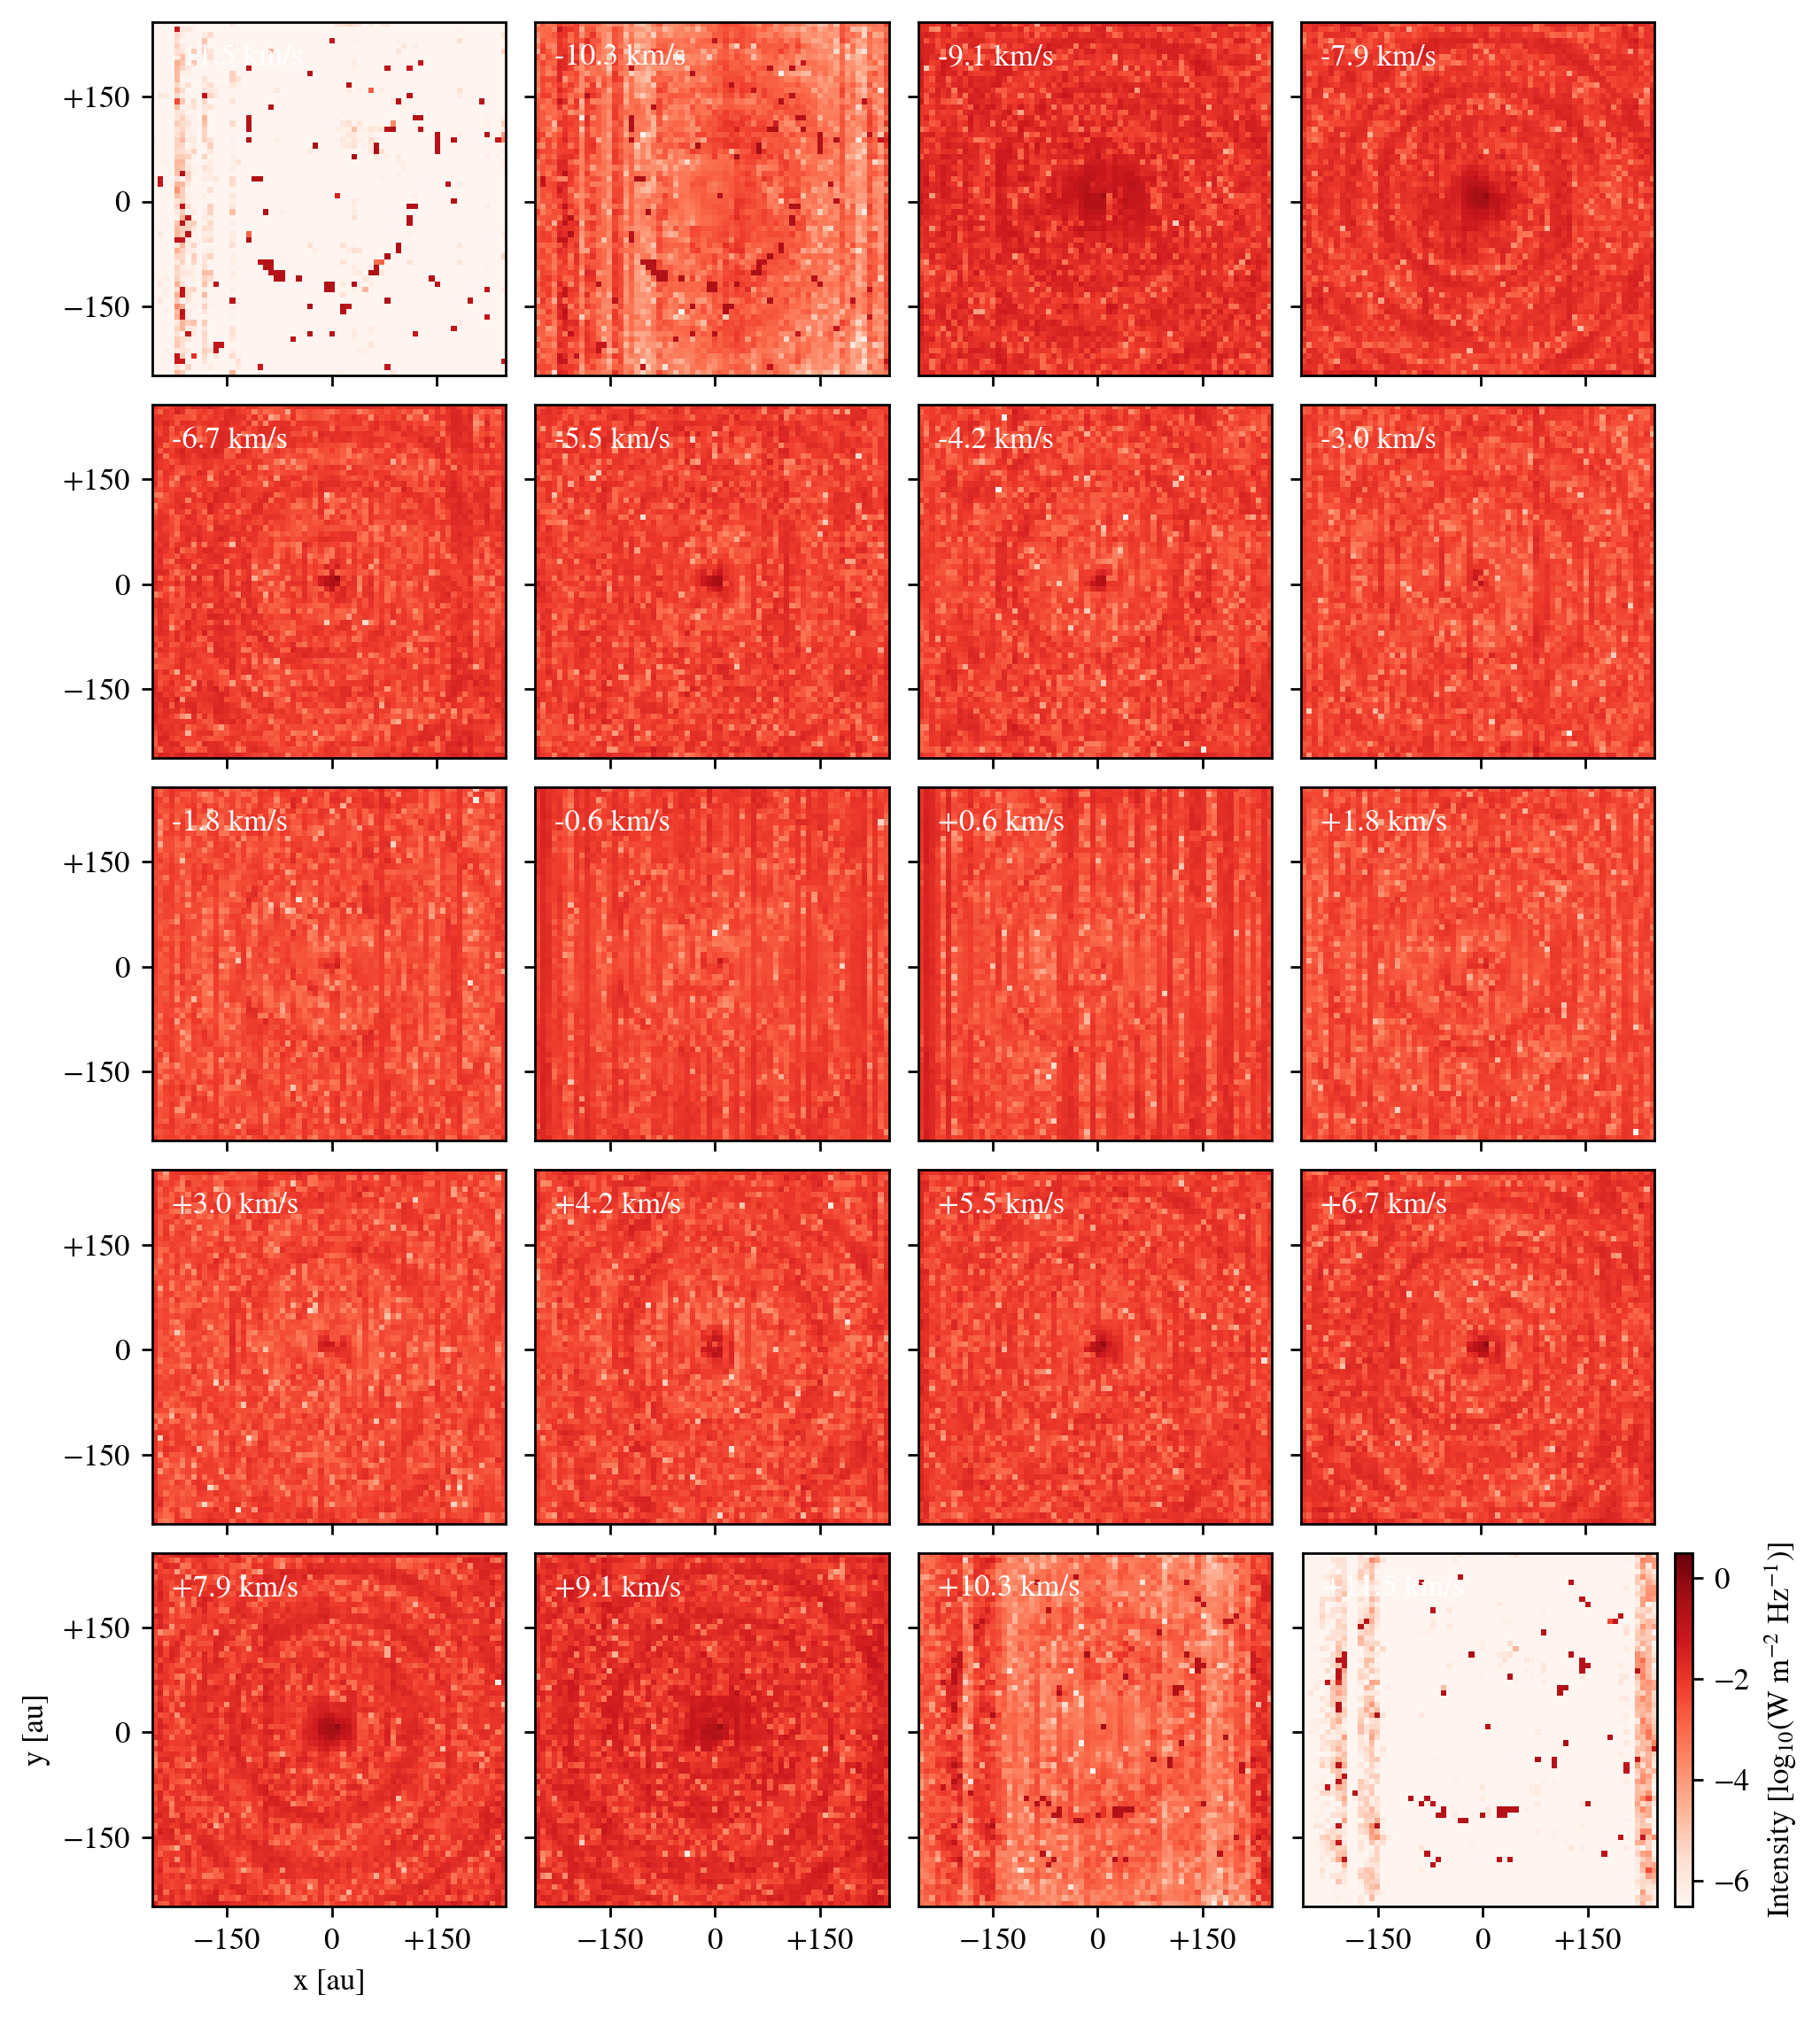

In [24]:
# obs = obss[1].data
obs = np.abs(((obss[1]-obss_2[1])/obss[1]).data)

vmin = -6.5 #np.log10(obs.min())
vmax =  0.5 #np.log10(obs.max())

fig, axes = plt.subplots(
    nrows       =   5,
    ncols       =   4,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (8.1, 9),
    gridspec_kw = {'wspace':0.00, 'hspace':0.00},
    layout      = 'constrained'
)

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(np.log10(obs[:,:,5*i+2]), vmin=vmin, vmax=vmax, cmap='Reds')
    ax.text(+3, +7.25, f'{velos[5*i+2]/1000:+.1f} km/s', color='white')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([13, 32, 51], ['$-150$', '$0$', '$+150$'])
    ax.set_yticks([13, 32, 51], ['$+150$', '$0$', '$-150$'])
    
axes[4,0].set_xlabel('x [au]')
axes[4,0].set_ylabel('y [au]')

fig.colorbar(pcm, ax=ax, location='right', shrink=1.0, pad=0.05, label='log$_{10}$ relative difference')

plt.savefig('phantom_SiO_obs_rec.png', dpi=360)

In [7]:
plot_cube_2D(np.log(obss[0]))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [8]:
obss_int = obss.sum(axis=(1,2))

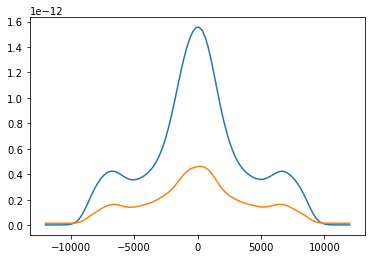

In [9]:
plt.plot(pmodel.velos, obss_int[0])
plt.plot(pmodel.velos, obss_int[1])

In [10]:
torch.save(obss, 'obss.pt')

In [11]:
model.save('model_truth.h5')